In [113]:
import matplotlib.pyplot as plt
import matplotlib._color_data as mcd
import matplotlib.colors as mplc

plt.rc('figure', dpi=100)

from jax.nn import softmax
from jax import grad, jit
import jax.numpy as jnp
from jax.experimental import optimizers

import numpy as np
import cv2

from IPython.display import display
import pandas as pd

In [ ]:
# fn = 3
# dendro_frames = []
# for frame_num in range(fn, fn+2):
#     orig = cv2.imread("gen/{:02d}.png".format(frame_num), cv2.IMREAD_GRAYSCALE).astype(np.float32)
#     im = cv2.GaussianBlur(orig, (3, 3), cv2.BORDER_CONSTANT)
#     d = make_dendrogram(-im)
#     dendro_frames.append(d)

In [46]:
import importlib
import dendrogram
importlib.reload(dendrogram)
from dendrogram import *

In [121]:
frames = []
max_val = 0
for frame_num in range(4):
    im = np.load('sim_data/z_{}.npy'.format(frame_num))
    im = cv2.resize(im, (300, 300)) # 300 x 300
    im = cv2.GaussianBlur(im, (3, 3), cv2.BORDER_CONSTANT)
    
    im[im < 1e-3] = 1e-3
    im = np.log10(im / 1e-3)
    
    frames.append(im)
    max_val = max(im.max(), max_val)
    
dendro_frames = []
for im in frames[:2]:
    print('.', end='')
    im /= max_val
    d = make_dendrogram(-im)    
    dendro_frames.append(d)

..

In [122]:
def cost(params, hyperparams, supplement):        

    cost_structure = 0
    cost_mass = 0
    cost_alignment = 0
    cost_src = 0
    
    hyp = hyperparams
    
    for t in range(len(params)):
        link_mat = softmax(params[t], axis=1)
        supp = supplement[t]
        mass_i, mass_j = supp['mass_i'], supp['mass_j']
        x_i, x_j = supp['x_i'], supp['x_j']
        cov_i, cov_j = supp['cov_i'], supp['cov_j']
        v_i_prior = supp['v_i_prior']
        metric_j = supp['metric_j']
        weights_j = supp['weights_j']
        local_pairs = supp['local_pairs_i']
        
        mass_mat_all = jnp.einsum('ij,i->ij', link_mat, mass_i)
        mass_mat = mass_mat_all[:-1, :-1]
        m_j = jnp.sum(mass_mat_all[:, :-1], axis=0)
        
        dE_structure = 0
        for i1, i2, weight in local_pairs:
            m1, m2 = mass_i[i1], mass_i[i2]
            m1, m2 = m1/(m1+m2), m2/(m1+m2)
            var_in = 0
            if i1 != i2:
                var_in = m1 * m2
            # not necessarily normalized (we ignore sink!)
            out_distr = m1 * link_mat[i1, :-1] + m2 * link_mat[i2, :-1]
            joint_distr = jnp.outer(out_distr, out_distr) * metric_j**2
            var_out = 0.5 * jnp.sum(joint_distr)
            penalty = (var_out - var_in)**2 / (2 * hyp.struct_sigma**2)
            dE_structure += weight * penalty
        
        chi = mass_j/m_j
        dm = (chi - hyp.mass_mu)**2 / chi
        penalties = dm**2 / (2 * hyp.mass_sigma**2)
        dE_mass = jnp.sum(penalties)
#         dE_mass = jnp.sum(weights_j * penalties) / jnp.sum(weights_j)
        
        dE_align = 0
        for j in range(len(x_j)):
            distr = mass_mat[:, j] / jnp.sum(mass_mat[:, j])
            mu_mix = jnp.einsum('i,ij->j', distr, (x_i + v_i_prior))
            mu_bar = jnp.einsum('i,ij->j', distr, x_i)
            d_mu = x_i - mu_bar
            outers = jnp.einsum('ij,ik->ijk', d_mu, d_mu)
            cov_mix = jnp.einsum('i,ijk->jk', distr, (cov_i + outers))
            
            mu_err = jnp.linalg.norm(mu_mix - x_j[j])
            cov_err = jnp.linalg.norm(cov_mix - cov_j[j])
            penalty = mu_err**2 / (2 * hyp.align_mu_sigma**2)
            penalty += cov_err**2 / (2 * hyp.align_cov_sigma**2)
            dE_align += penalty / len(x_j)
            

        dE_src = hyp.srcsink * (jnp.sum(mass_mat_all[-1, :-1]) \
                                + jnp.sum(mass_mat_all[:-1, -1]))

        cost_structure += dE_structure
        cost_mass += dE_mass
        cost_alignment += dE_align
        cost_src += dE_src

#     print('costs')
#     print(cost_structure, cost_mass, cost_alignment, cost_src)
    return cost_structure + cost_mass + cost_alignment + cost_src

dcost = jit(grad(cost, argnums=0), static_argnums=(1,2))
cost = jit(cost, static_argnums=(1,2))

In [112]:
print(cost(params, hyp, supplement))

# params2 = np.array(params[0])
# bump = 100
# params2[0, 0] += bump
# params2[1, 2] += bump
# params2[2, 3] += bump
# params2[7, 11] += bump
# params2[9, 11] += bump
# params2[5, 12] += bump
# print(cost([params2], hyp, supplement))

costs
169438.95 147030.81 0 203.28882
316673.03


In [123]:
class Hyperparams:
    align_mu_sigma = 10
    align_cov_sigma = 1
    struct_sigma = 0.5
    mass_mu = 1
    mass_sigma = .01
    vel_mu = 15
    srcsink = 3000
    r_mid = 70

def initialize_params(d, d_next):
    param_mat = np.zeros((d.N+1, d_next.N+1))
    v_mat = np.zeros((d.N, d_next.N, 2))
    for i, j in np.ndindex(d.N, d_next.N):
        displacement = d_next.branches[j].x - d.branches[i].x
        v_mat[i, j, :] = displacement
        # equal weighting necessary to prevent locality term from doing wonky things
        if np.linalg.norm(displacement) < 20:
            param_mat[i, j] = 1
    for j in range(d_next.N):
        dist = np.linalg.norm(d_next.branches[j].x)
        r_mid = Hyperparams.r_mid
        if dist < r_mid:
            param_mat[-1, j] = 1 - dist/r_mid
    return param_mat, v_mat

def gen_supplement(d, d_next):
    s = {}
    s['mass_i'] = d.masses
    s['mass_j'] = d_next.masses[:-1]
    s['x_i'] = d.x
    s['x_j'] = d_next.x
    s['cov_i'] = np.array([b.covariance for b in d.branches])
    s['cov_j'] = np.array([b.covariance for b in d_next.branches])
    s['v_i_prior'] = [hyp.vel_mu * x / np.linalg.norm(x) for x in d.x]
    s['metric_j'] = d_next.metric
    s['weights_j'] = np.array([b.mass_frac for b in d_next.branches])
    
    local_pairs = []
    for i1, i2 in np.ndindex(*d.metric.shape):
        if (i1 <= i2) and d.metric[i1, i2] <= 1:
            weight = d.masses[i1] + d.masses[i2] / (np.sum(d.masses[:-1]))
            local_pairs.append((i1, i2, weight))
    s['local_pairs_i'] = local_pairs
    return s

hyp = Hyperparams()
supplement = []
params = []
for t in range(len(dendro_frames)-1):
    d = dendro_frames[t]
    d_next = dendro_frames[t+1]
    param_frame, v_frame = initialize_params(d, d_next)
    params.append(param_frame)    
    supp = gen_supplement(d, d_next)    
#     supp['vel_mat'] = v_frame
    supplement.append(supp)

print(cost(params, hyp, supplement))

opt_init, opt_update, get_params = optimizers.adam(step_size=1)

@jit
def update(i, opt_state):
    params = get_params(opt_state)
    return opt_update(i, dcost(params, hyp, supplement), opt_state)

opt_state = opt_init(params)

for step in range(7000):
    opt_state = update(step, opt_state)

params = get_params(opt_state)
print(cost(params, hyp, supplement))
print()

70864445000.0
272615.12



[214239.   8935.    252.   6835.    792.   5865.   7746.    418.   1212.    504.    358.]
[205641.  15452.   7089.    837.  26195.    281.   8452.   2664.     48.     13.    905.   1826.   5640.]


,0,1,2,3,4,5,6,7,8,9,10,11,12,sink
0,206446,4469,819,11,2266,16,125,41,0,0,14,14,18,0
1,8934,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,0,252,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,5440,0,1,0,0,0,0,0,1392,0
4,0,0,792,0,0,0,0,0,0,0,0,0,0,0
5,5857,0,0,0,6,0,1,0,0,0,0,0,1,0
6,1,0,0,0,11,0,6039,1098,0,0,357,238,1,0
7,0,0,0,0,0,0,0,0,0,0,0,0,418,0
8,0,898,0,311,0,0,1,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,503,0,0


,0,2,3,5,8,9,10,11,12,sink
0,206446,819,11,16,0,0,14,14,18,0
1,8934,0,0,0,0,0,0,0,0,0
2,0,252,0,0,0,0,0,0,0,0
4,0,792,0,0,0,0,0,0,0,0
5,5857,0,0,0,0,0,0,0,1,0
7,0,0,0,0,0,0,0,0,418,0
8,0,0,311,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,503,0,0
10,0,0,0,319,29,9,0,0,0,0
src,0,0,0,0,0,0,0,0,0,214239


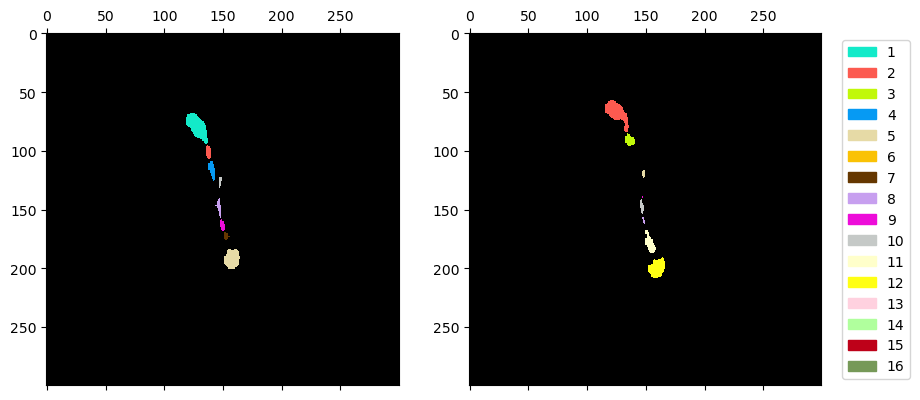

In [124]:
np.set_printoptions(suppress=True)
np.set_printoptions(edgeitems=30, linewidth=100000)
import matplotlib.patches as mpatches

colornames = ["aqua", "coral", "chartreuse", "azure",
              "beige", "goldenrod", "brown", "lavender",
              "fuchsia", "silver", "ivory", "yellow",
              "light pink", "pastel green", "scarlet", "moss"
             ]
colors = [255*np.array(mplc.to_rgb("xkcd:" + c)) for c in colornames]
patches = []
for i, cname in enumerate(colornames):
    patches.append(mpatches.Patch(color="xkcd:"+cname, label=str(i+1)))
    
def color(img, branch):    
    if branch.mass_frac > 0.95:
        for x, y in branch.region:
            img[x, y, :] = colors[(branch.id-1) % len(colors)]
        
    for c in branch.children:
        color(img, c)

for t in range(len(params)):
    p = params[t]
    d = dendro_frames[t]
    d_next = dendro_frames[t+1]
    mass_mat = np.einsum('ij,i->ij', softmax(p, axis=1), d.masses)
    mass_frac_mat = np.einsum('ij,j->ij', mass_mat, 1/(np.sum(mass_mat, axis=0))) * 100
    mass_frac_mat = np.round(mass_frac_mat)
    df = pd.DataFrame(mass_mat.round().astype(int),
                      index=list(range(d.N))+['src'],
                      columns=list(range(d_next.N))+['sink'])
    print(d.masses[:-1])
    print(d_next.masses[:-1])
    display(df)
    for b in d.branches:
        if b.mass_frac <= 0.8:
            df = df.drop(b.id, axis=0)
    for b in d_next.branches:
        if b.mass_frac <= 0.8:
            df = df.drop(b.id, axis=1)
    display(df)
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    img1 = np.zeros((*d.im.shape, 3), dtype=int)
    for c in d.root.children:
        color(img1, c)
    axes[0].matshow(img1)
    
    img2 = np.zeros((*d_next.im.shape, 3), dtype=int)
    for c in d_next.root.children:
        color(img2, c)
    axes[1].matshow(img2)
    
    plt.legend(handles=patches, bbox_to_anchor=(1.04,1), loc="upper left")
    plt.show()
    
    
    print('====================================')

In [11]:
def assign_trajectories(dendro_frames, params):
    traj_counter = 0
    thresh = 0.9
    thresh2 = 0.25
    for b in dendro_frames[0].branches:
        if b.mass_frac > thresh:
            b.traj_id = traj_counter
            traj_counter += 1
    for t in range(len(dendro_frames)-1):
        p = params[t]
        d = dendro_frames[t]
        d_next = dendro_frames[t+1]
        
        mass_mat = np.einsum('ij,i->ij', softmax(p[:, :, 0], axis=1), d.masses)
        
        for branch_id in range(d_next.N):
            branch = d_next.branches[branch_id]
            if branch.mass_frac < thresh or branch.traj_id is not None:
                continue
            mass_breakdown = np.einsum('ij,j->i', mass_mat[:, :-1], d_next.hierarchy[branch_id])
            mass_breakdown = mass_breakdown / np.sum(mass_breakdown)
            sorted_inds = np.flip(np.argsort(mass_breakdown))
            traj_id = None
            for ind in sorted_inds:
                if ind == d.N:
                    m_frac = mass_breakdown[ind]
                    if m_frac > thresh2:
                        break
                elif d.branches[ind].traj_id is not None:
                    traj_id = d.branches[ind].traj_id
                    break
            if traj_id == None:
                traj_id = traj_counter
                traj_counter += 1
            
            for twig in branch.list_descendants():
                twig.traj_id = traj_id
                
for d in dendro_frames:
    for b in d.branches:
        b.traj_id = None
assign_trajectories(dendro_frames, params)


def draw_traj(dendro_frames):
    colors = ["aqua", "coral", "chartreuse", "azure",
              "beige", "goldenrod", "brown", "lavender",
              "fuchsia", "silver", "ivory", "yellow"]
    colors = [255*np.array(mplc.to_rgb("xkcd:" + c)) for c in colors]
    
    for t in range(len(dendro_frames)):
        im = np.zeros((200, 200, 3))
        for b in dendro_frames[t].branches:
            if b.mass_frac > 0.9:
                for x, y in b.full_region:
                    im[x, y, :] = colors[b.traj_id % len(colors)]
        cv2.imwrite("results/traj-attempt6/traj-{:02d}.png".format(t), im)

draw_traj(dendro_frames)
